Heatmap with PETS.

In [ ]:
from tensorflow import keras
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.datasets
from tensorflow.keras import regularizers


In [ ]:
import os
orig_data_dir = os.getcwd()+'/images'
train_dir = os.getcwd()+"/TRAIN"
test_dir = os.getcwd()+"/TEST"
txt_file_train = os.getcwd()+'/annotations/trainval.txt'
txt_file_test = os.getcwd()+'/annotations/test.txt'

if not os.path.isdir(train_dir):
  !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

if not os.path.isdir(train_dir):
  !tar -xvf images.tar.gz

if not os.path.isdir(train_dir):
  !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

if not os.path.isdir(train_dir):
  !tar -xvf annotations.tar.gz

In [ ]:
import os
if not os.path.isdir('k'):
  !git clone https://github.com/joaopauloschuler/k-neural-api.git -b development15 k
else:
  !cd k && git pull
!cd k && pip install .

Cloning into 'k'...
remote: Enumerating objects: 1598, done.
remote: Counting objects: 100% (1047/1047), done.
remote: Compressing objects: 100% (687/687), done.
remote: Total 1598 (delta 758), reused 616 (delta 355), pack-reused 551
Receiving objects: 100% (1598/1598), 15.08 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (1114/1114), done.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.6-py3-none-any.whl size=60100 sha256=2d8ce28197135e05e5c42cf9eeb3ed33ae15cf08f978b9dfa111279c6c5eb2ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-itae98n1/wheels/c1/8a/57/56dbba25eff58e52e53

In [ ]:
import cai.datasets
import cai.efficientnet
import cai.gradientascent
import numpy as np
from tensorflow import keras
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
from sklearn.metrics import classification_report
import shutil

Tensorflow version: 2.8.0
Keras version: 2.8.0


In [ ]:
def CopyImagesToFolders(orig_data_dir, dest_data_dir, txt_file, verbose=True, prefix='class_'):
  # Load the CSV file.
  # Image CLASS-ID SPECIES BREED ID
  if verbose: print('Loading', txt_file)
  with open (txt_file, "r") as myfile:
    csv_lines=myfile.readlines()

  # Transform the CSV file into an array  
  line_count = 0
  a_lines = []
  for str_line in csv_lines:
    if line_count > 0: 
      a_line = str_line.replace('\n', '').split(' ')
      a_lines.append(a_line)
    line_count = line_count + 1
  
  # create destination folder
  if not os.path.isdir(dest_data_dir):
    os.mkdir(dest_data_dir)

  # Save cropped images
  line_count = 0
  failed_count = 0
  original_count = 0
  last_image_file = ''
  for a_line in a_lines:
    dest_folder_name = dest_data_dir+'/'+prefix+a_line[1]
    dest_file_name = dest_folder_name+'/'+a_line[0]
    orig_file_name = orig_data_dir+'/'+ a_line[0]
    found = False
    if os.path.isfile(orig_file_name+'.jpg'):
      dest_file_name = dest_folder_name+'/'+a_line[0]+'.jpg'
      orig_file_name = orig_data_dir+'/'+ a_line[0]+'.jpg'
      found = True
    if os.path.isfile(orig_file_name+'.png'):
      dest_file_name = dest_folder_name+'/'+a_line[0]+'.png'
      orig_file_name = orig_data_dir+'/'+ a_line[0]+'.png'
      found = True
    if verbose: print(line_count,':', a_line, dest_file_name)
    if (found):
      if not os.path.isdir(dest_folder_name):
        os.mkdir(dest_folder_name)
      if verbose: print('Copying file from', orig_file_name,'to',dest_file_name)
      shutil.copyfile(orig_file_name, dest_file_name)
    else:
      if verbose: print('File does not exist:', orig_file_name)
      failed_count = failed_count + 1
    line_count = line_count + 1
  print("Processed files:", line_count, "Failed count: ", failed_count, "Original count:", original_count)

In [ ]:
if not os.path.isdir(train_dir):
  CopyImagesToFolders(orig_data_dir=orig_data_dir, dest_data_dir=train_dir, txt_file=txt_file_train, verbose=True, prefix='class_')
if not os.path.isdir(test_dir):
  CopyImagesToFolders(orig_data_dir=orig_data_dir, dest_data_dir=test_dir, txt_file=txt_file_test, verbose=True, prefix='class_')
print(os.listdir(train_dir))
print(os.listdir(test_dir))

In [ ]:
num_classes = 37
batch_size = 32
epochs = 150
target_size_x = 224 # default value is 224
target_size_y = 224 # default value is 224

In [ ]:
train_x, val_x, aux_test_x, train_y, val_y, aux_test_y, classweight, classes = cai.datasets.load_images_from_folders(seed=7,
  root_dir=train_dir, lab=False, 
  verbose=True, bipolar=False, base_model_name='oxford_pets',
  has_training=True, has_validation=True, has_testing=False,
  training_size=0.9, validation_size=0.1, test_size=0.0,
  smart_resize=True,
  target_size=(target_size_x, target_size_y))

aux_train_x, aux_val_x, test_x, aux_train_y, aux_val_y, test_y, classweight, classes = cai.datasets.load_images_from_folders(seed=7,
  root_dir=test_dir, lab=False, 
  verbose=True, bipolar=False, base_model_name='oxford_pets',
  has_training=False, has_validation=False, has_testing=True,
  smart_resize=True,
  training_size=0.0, validation_size=0.0, test_size=1,
  target_size=(target_size_x, target_size_y))

print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

Loading  37  classes.
smart resize is enabled.
loading train images
train shape is: (3309, 224, 224, 3)
loading validation images
validation shape is: (370, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 1.0
Channel  2  min: 0.0  max: 1.0
Loaded.
Loading  37  classes.
smart resize is enabled.
loading test images
test shape is: (3668, 224, 224, 3)
Loaded.
(3309, 224, 224, 3) (370, 224, 224, 3) (3668, 224, 224, 3)
(3309, 37) (370, 37) (3668, 37)


# Build the Model/Neural Network

In [ ]:
import cai.densenet
import cai.util
input_shape = (target_size_x, target_size_y, 3)

best_result_file_name = 'JP30D09-EfficientNet-OxfordIIIPetDataset-2-best_result.hdf5'
model = model = cai.models.load_kereas_model(best_result_file_name)

model.summary(line_length=250)

Model: "kEffNet-b0"
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                     Output Shape                                           Param #                       Connected to                                                                       
 input_3 (InputLayer)                                                             [(None, None, None, 3)]                                0                             []                                                                                 
                                                                                                                                                                                                                                   

# Show Activation Maps

image 0 has class 0
heat_map min: 0.0  heat_map max: 1.0


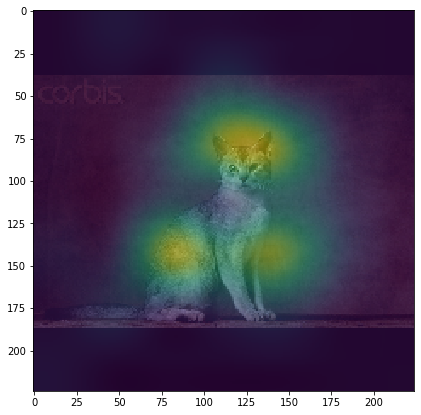

image 1 has class 0
heat_map min: 0.0  heat_map max: 1.0


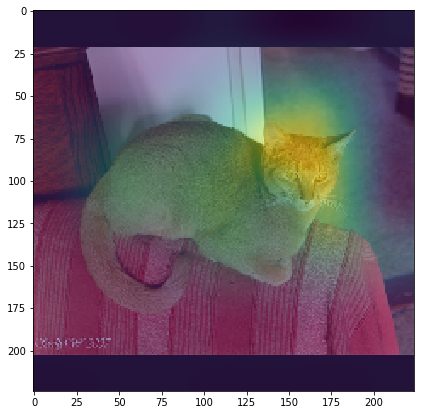

image 2 has class 0
heat_map min: 0.0  heat_map max: 1.0


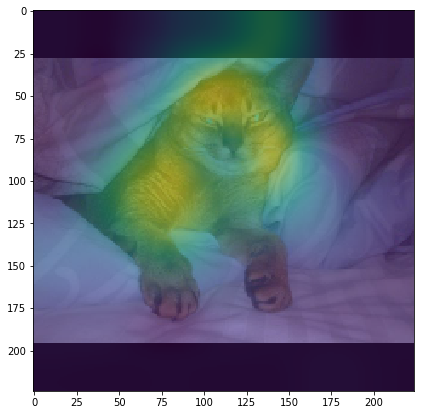

image 3 has class 0
heat_map min: 0.0  heat_map max: 1.0


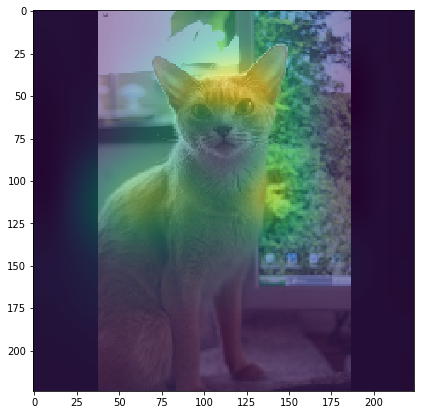

image 4 has class 0
heat_map min: 0.0  heat_map max: 1.0


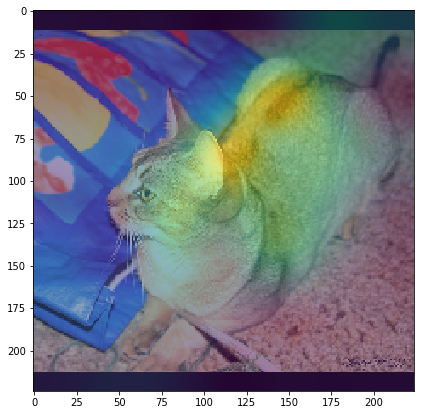

image 5 has class 0
heat_map min: 0.0  heat_map max: 1.0


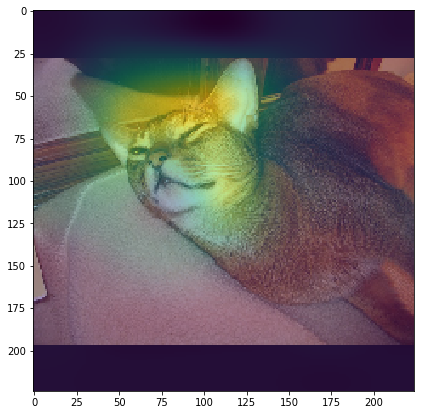

image 6 has class 0
heat_map min: 0.0  heat_map max: 1.0


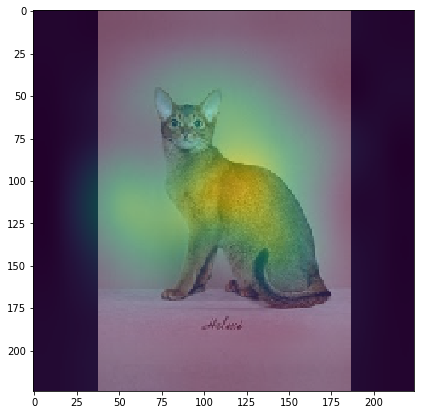

image 7 has class 0
heat_map min: 0.0  heat_map max: 1.0


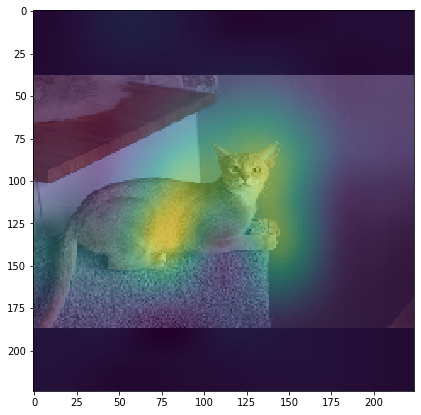

image 8 has class 0
heat_map min: 0.0  heat_map max: 1.0


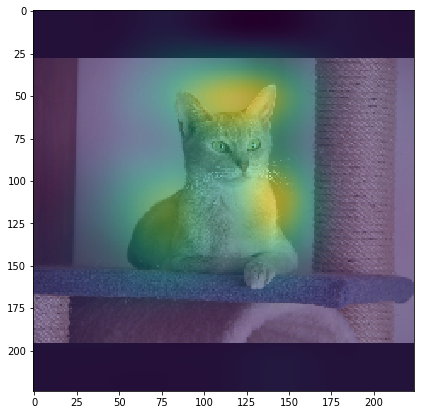

image 9 has class 0
heat_map min: 0.0  heat_map max: 1.0


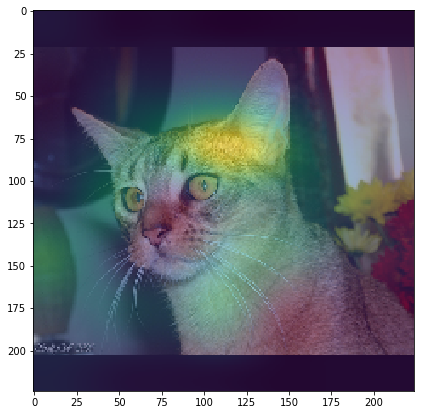

image 10 has class 0
heat_map min: 0.0  heat_map max: 1.0


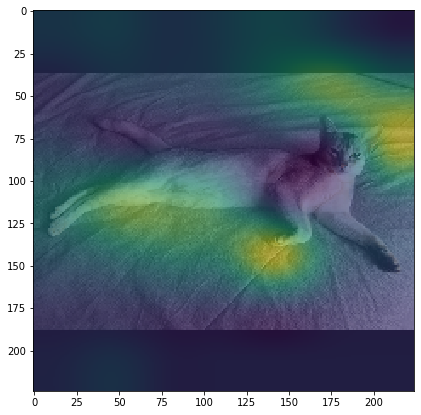

image 11 has class 0
heat_map min: 0.0  heat_map max: 1.0


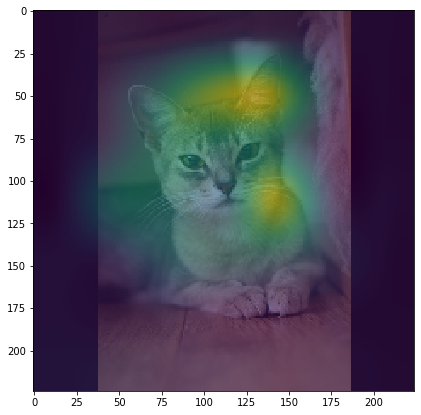

image 12 has class 0
heat_map min: 0.0  heat_map max: 1.0


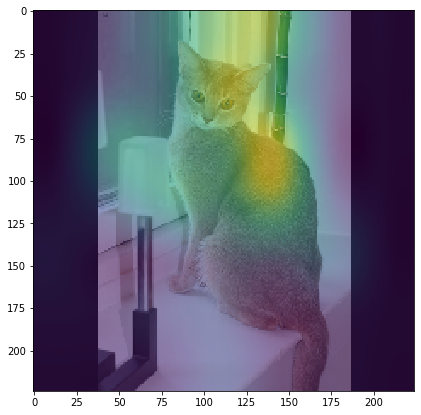

image 13 has class 0
heat_map min: 0.0  heat_map max: 1.0


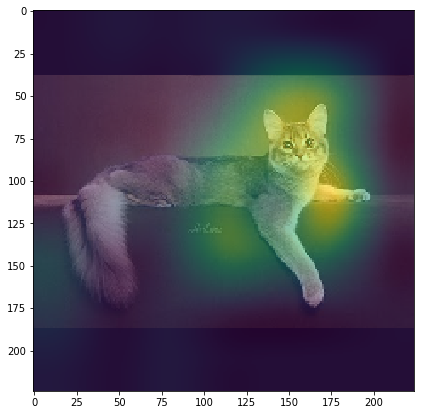

image 14 has class 0
heat_map min: 0.0  heat_map max: 1.0


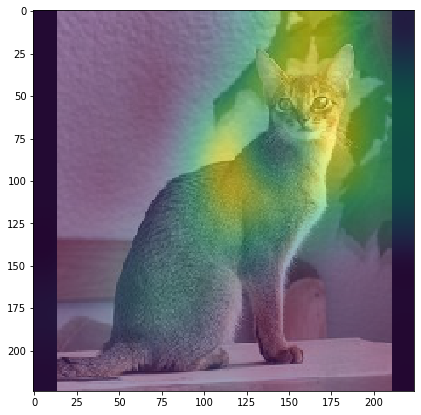

image 15 has class 0
heat_map min: 0.0  heat_map max: 1.0


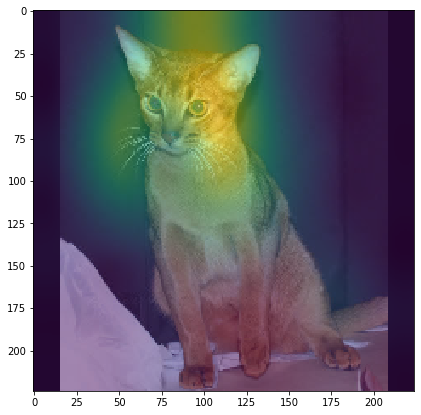

image 16 has class 0
heat_map min: 0.0  heat_map max: 1.0


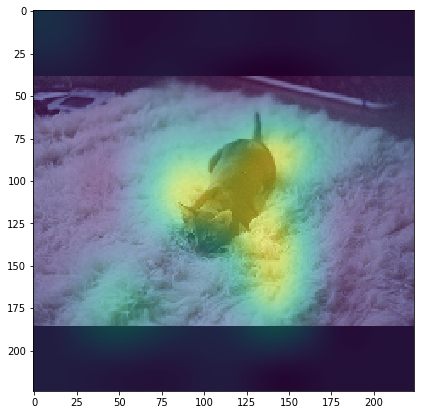

image 17 has class 0
heat_map min: 0.0  heat_map max: 1.0


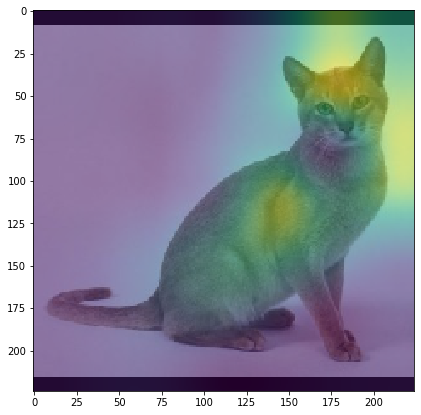

image 18 has class 0
heat_map min: 0.0  heat_map max: 1.0


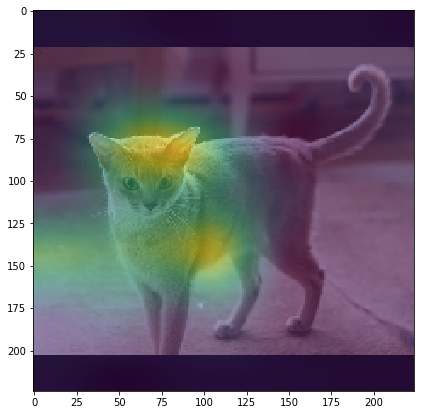

image 19 has class 0
heat_map min: 0.0  heat_map max: 1.0


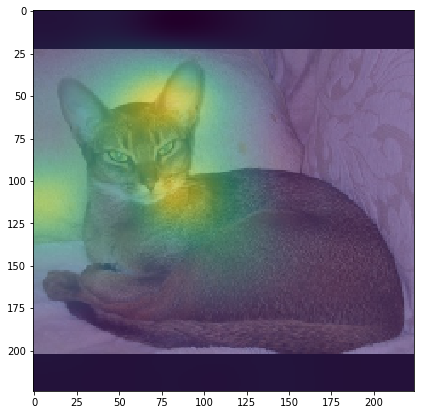

image 20 has class 0
heat_map min: 0.0  heat_map max: 1.0


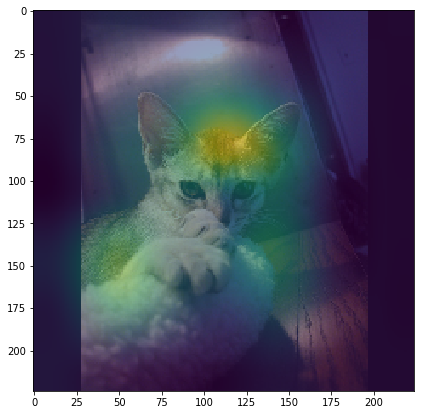

image 21 has class 0
heat_map min: 0.0  heat_map max: 1.0


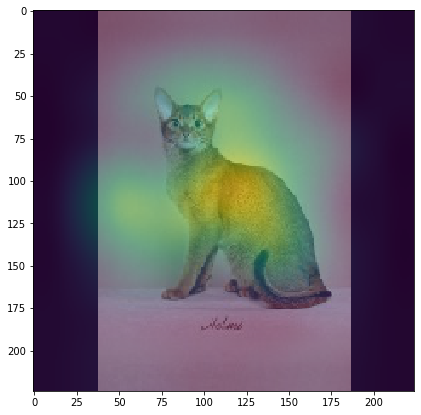

image 22 has class 0
heat_map min: 0.0  heat_map max: 1.0


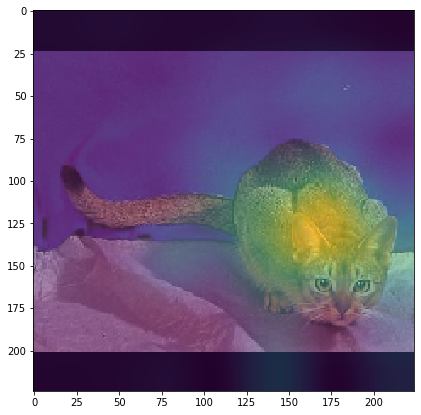

image 23 has class 0
heat_map min: 0.0  heat_map max: 1.0


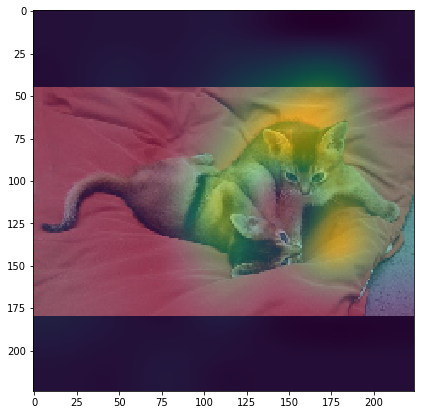

image 24 has class 0
heat_map min: 0.0  heat_map max: 1.0


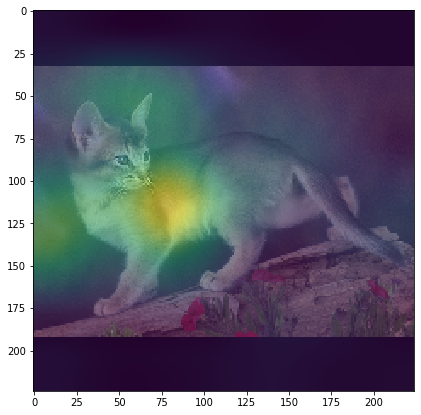

image 25 has class 0
heat_map min: 0.0  heat_map max: 1.0


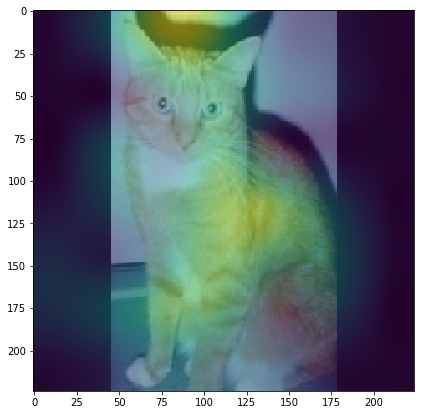

image 26 has class 0
heat_map min: 0.0  heat_map max: 1.0


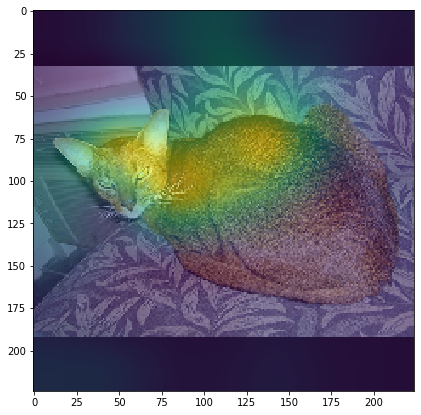

image 27 has class 0
heat_map min: 0.0  heat_map max: 1.0


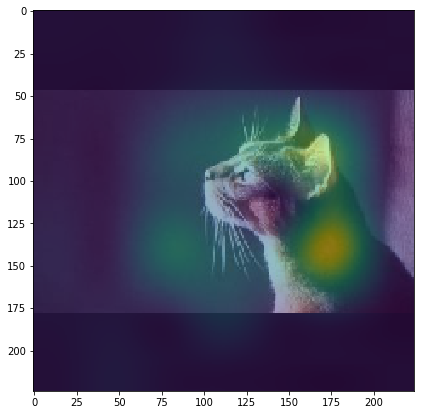

image 28 has class 0
heat_map min: 0.0  heat_map max: 1.0


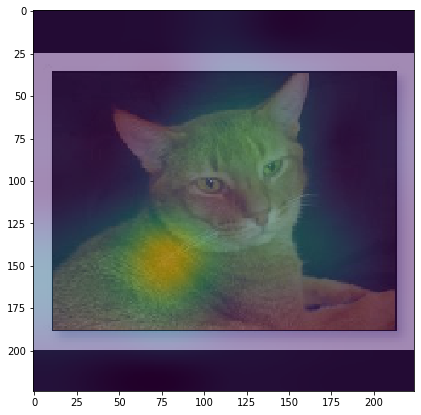

image 29 has class 0
heat_map min: 0.0  heat_map max: 1.0


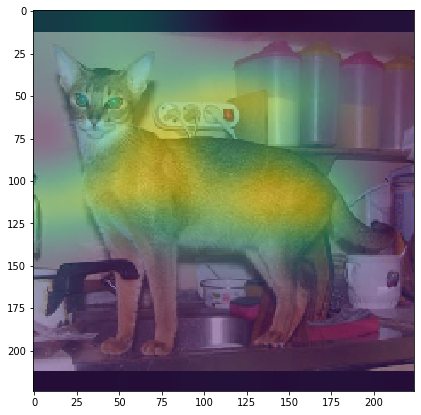

In [ ]:
import cai.models
import numpy as np
import cv2
import matplotlib.pyplot as plt

for image_position in range(30):
  image_class = np.argmax(train_y[image_position])
  image_class = np.argmax(train_y[image_position])
  print('image', image_position, 'has class', image_class)
  localImageArray = []
  localImageArray.append(train_x[image_position])
  localImageArray = np.array(localImageArray, dtype='float32')
  heat_map = cai.models.calculate_heat_map_from_dense_and_avgpool(aInput=localImageArray[0], target_class=image_class, pModel=model, pOutputLayerName='k_top_conv_group_interleaved', pDenseLayerName='k_probs')
  heat_map_res = cv2.resize(heat_map, dsize=(localImageArray[0].shape[0], localImageArray[0].shape[1]), interpolation=cv2.INTER_CUBIC)

  print('heat_map min:', np.min(heat_map), ' heat_map max:', np.max(heat_map))
  plt.figure(figsize = (7, 7))
  plt.imshow(heat_map_res, interpolation='nearest', aspect='equal', alpha=1)
  plt.imshow(localImageArray[0], interpolation='nearest', aspect='equal', alpha=0.5)
  plt.show()

In [ ]:
best_result_file_name = 'JP30D09-EfficientNet-OxfordIIIPetDataset--1-best_result.hdf5'
model = model = cai.models.load_kereas_model(best_result_file_name)

model.summary(line_length=180)

Model: "efficientnet-b0"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 input_4 (InputLayer)                                      [(None, None, None, 3)]                 0                    []                                                          
                                                                                                                                                                                    
 stem_conv_pad (ZeroPadding2D)                             (None, None, None, 3)                   0                    ['input_4[0][0]']                                           
                                                                      

image 0 has class 0
original image + heatmap:


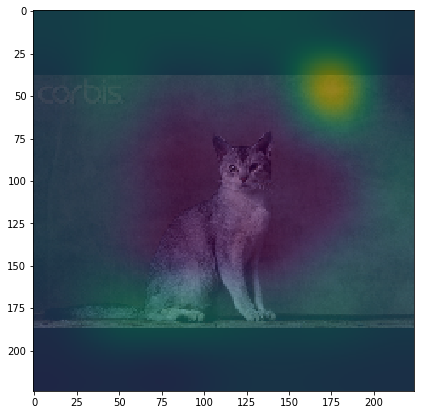

image 1 has class 0
original image + heatmap:


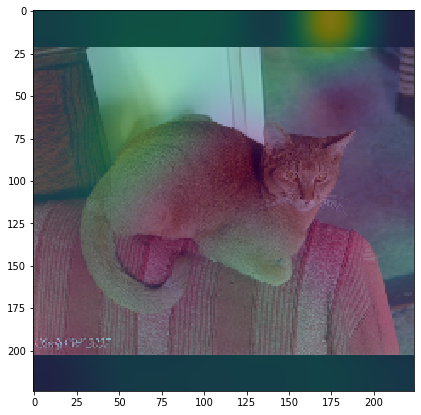

image 2 has class 0
original image + heatmap:


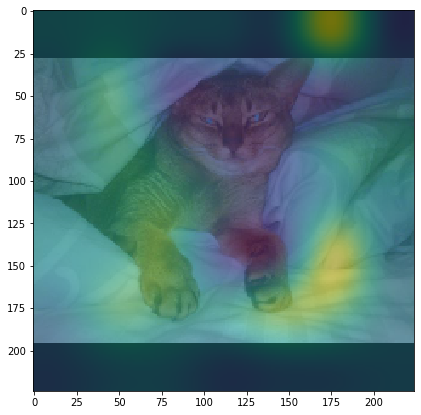

image 3 has class 0
original image + heatmap:


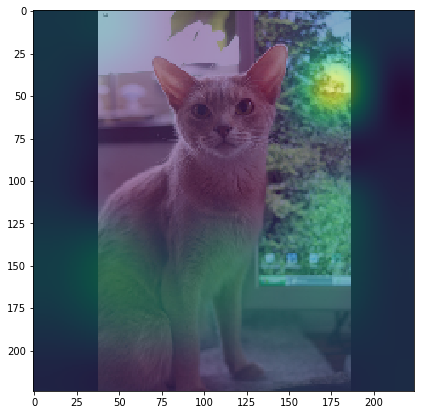

image 4 has class 0
original image + heatmap:


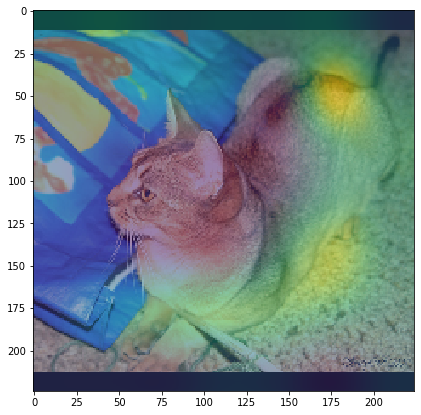

image 5 has class 0
original image + heatmap:


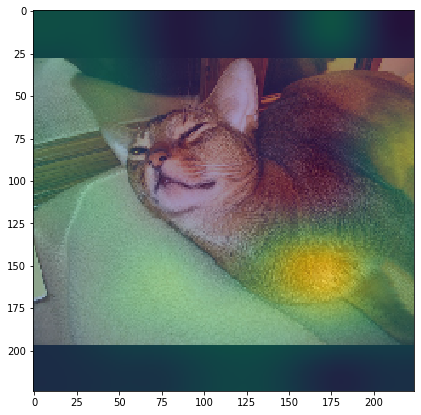

image 6 has class 0
original image + heatmap:


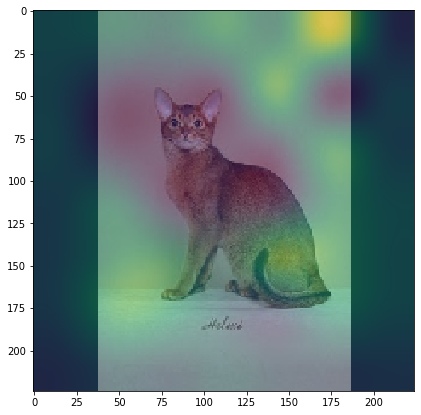

image 7 has class 0
original image + heatmap:


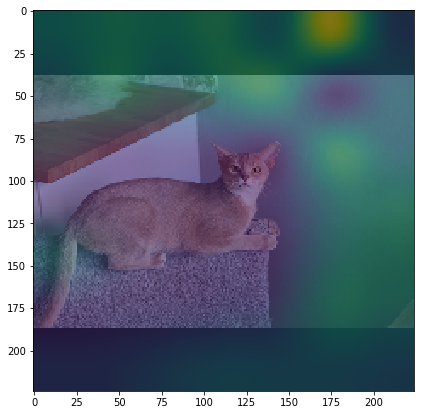

image 8 has class 0
original image + heatmap:


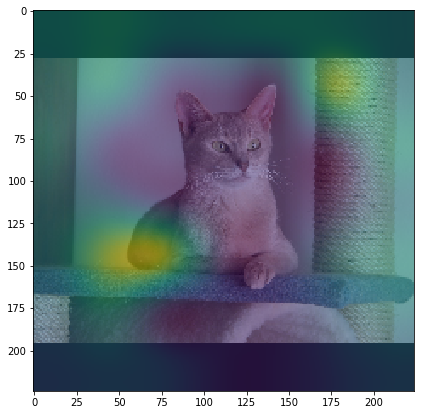

image 9 has class 0
original image + heatmap:


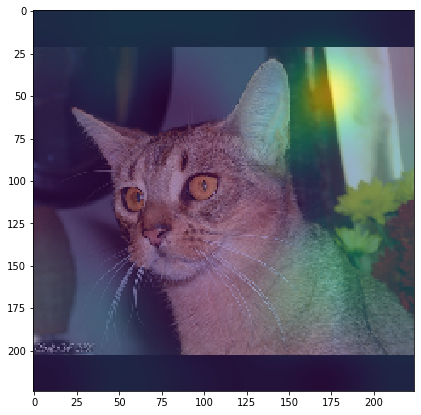

image 10 has class 0
original image + heatmap:


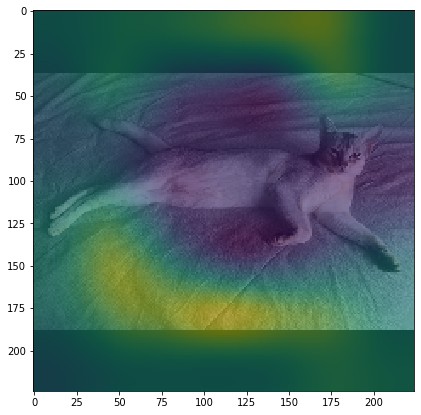

image 11 has class 0
original image + heatmap:


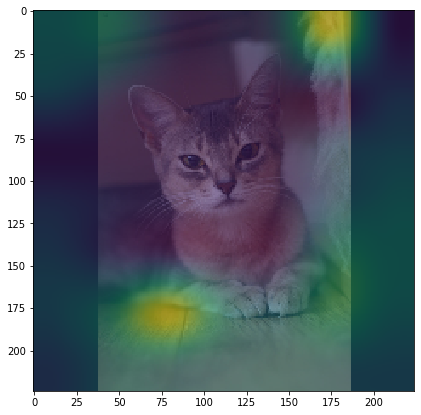

image 12 has class 0
original image + heatmap:


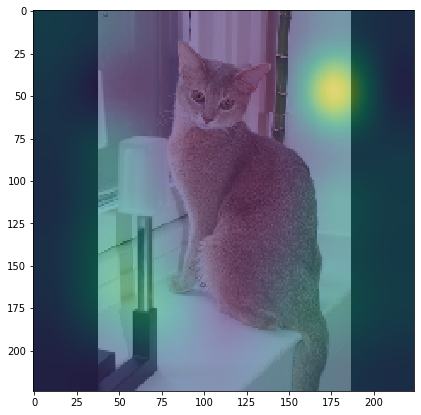

image 13 has class 0
original image + heatmap:


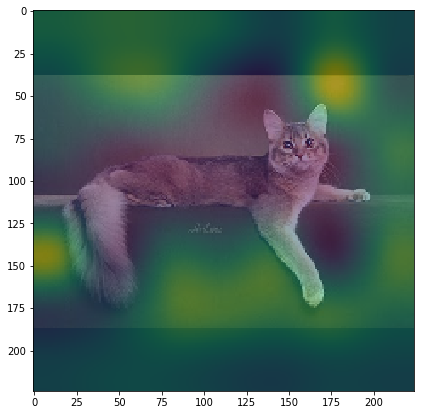

image 14 has class 0
original image + heatmap:


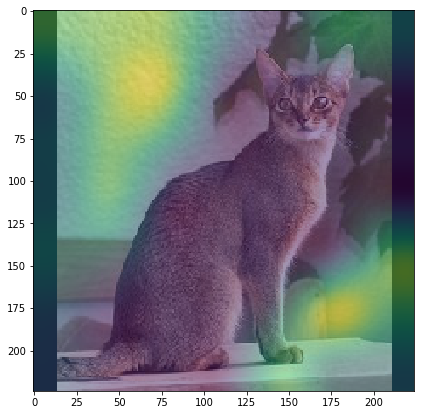

image 15 has class 0
original image + heatmap:


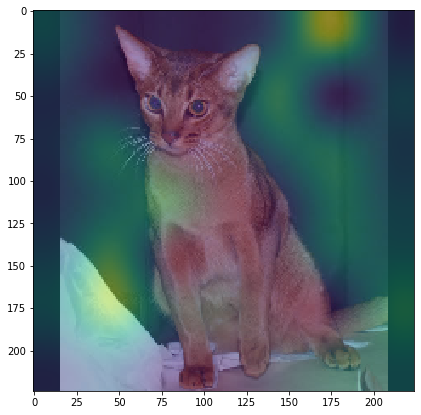

image 16 has class 0
original image + heatmap:


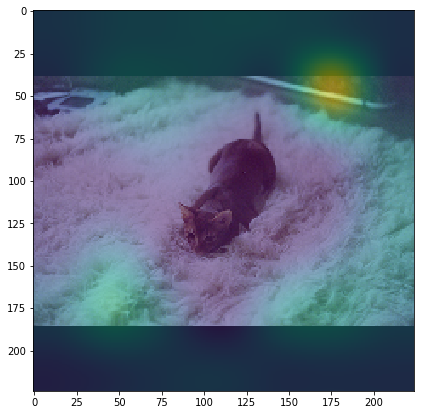

image 17 has class 0
original image + heatmap:


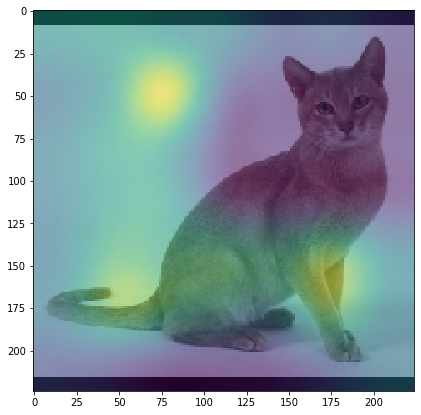

image 18 has class 0
original image + heatmap:


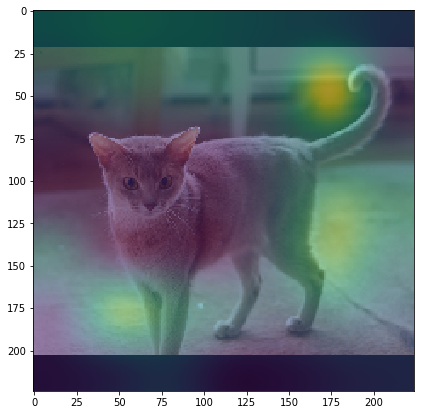

image 19 has class 0
original image + heatmap:


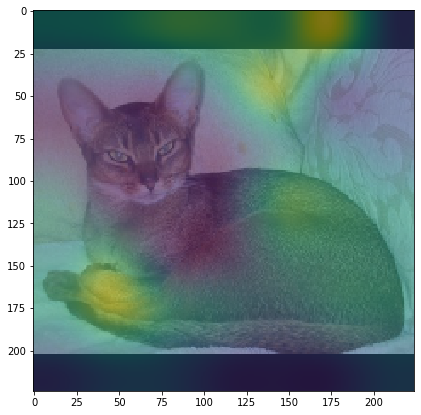

image 20 has class 0
original image + heatmap:


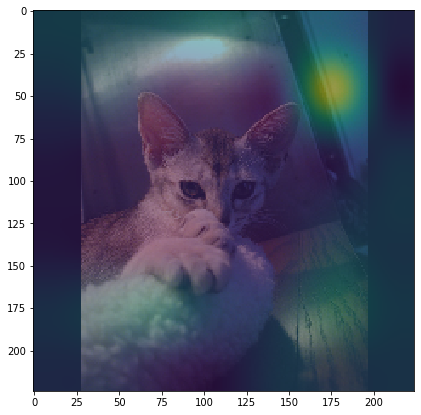

image 21 has class 0
original image + heatmap:


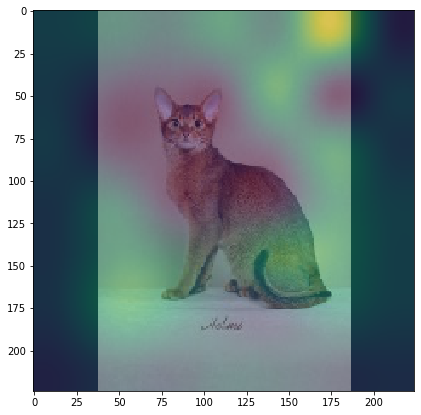

image 22 has class 0
original image + heatmap:


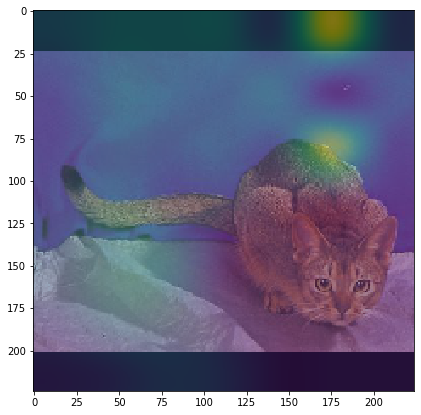

image 23 has class 0
original image + heatmap:


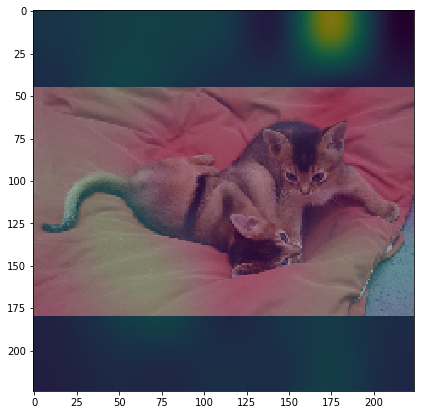

image 24 has class 0
original image + heatmap:


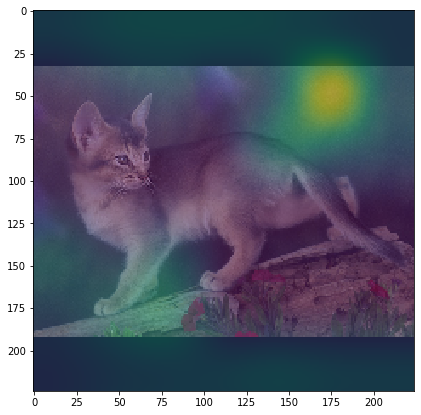

image 25 has class 0
original image + heatmap:


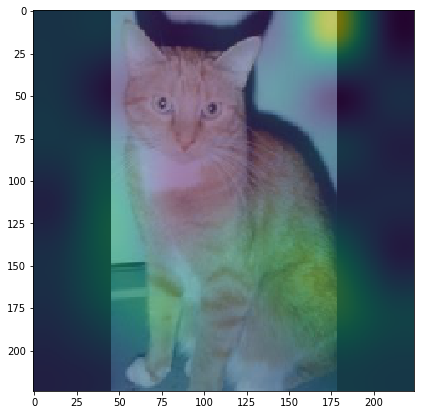

image 26 has class 0
original image + heatmap:


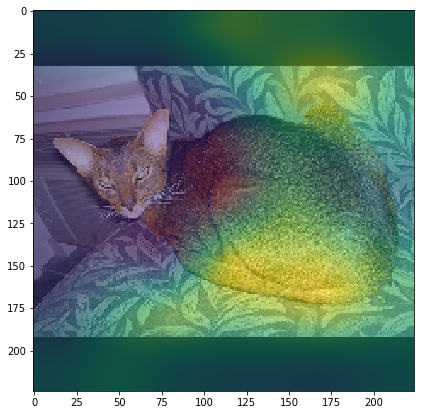

image 27 has class 0
original image + heatmap:


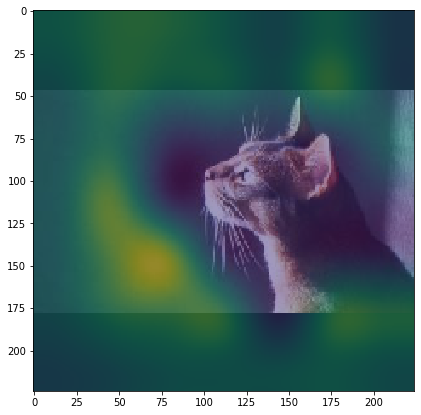

image 28 has class 0
original image + heatmap:


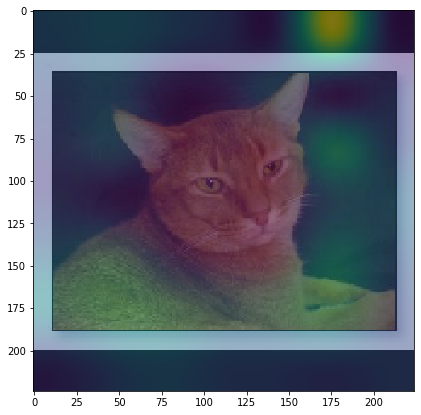

image 29 has class 0
original image + heatmap:


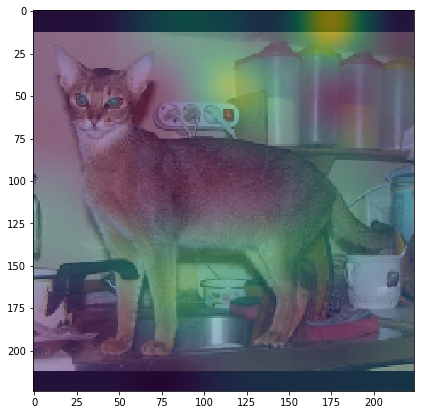

In [ ]:
for image_position in range(30):
  image_class = np.argmax(train_y[image_position])
  print('image', image_position, 'has class', image_class)
  localImageArray = []
  localImageArray.append(train_x[image_position])
  localImageArray = np.array(localImageArray, dtype='float32')
  heat_map = cai.models.calculate_heat_map_from_dense_and_avgpool(aInput=localImageArray[0], target_class=image_class, pModel=model, pOutputLayerName='top_activation', pDenseLayerName='probs')
  heat_map_res = cv2.resize(heat_map, dsize=(localImageArray[0].shape[0], localImageArray[0].shape[1]), interpolation=cv2.INTER_CUBIC)

  print('original image + heatmap:')
  plt.figure(figsize = (7, 7))
  plt.imshow(heat_map_res, interpolation='nearest', aspect='equal', alpha=1)
  plt.imshow(localImageArray[0], interpolation='nearest', aspect='equal', alpha=0.5)
  plt.show()